### CNN 텍스트 유사도 분석 모델
이번에는 딥러닝 모델로 한 번 텍스트 유사도를 측정해보자.  
4장에서도 사용했던 **합성곱 신경망 구조** 를 활용해보자.  

기본적인 구조는 이전 장의 합성곱 모델과 유사하나 이번에는 각 데이터가 두 개의 텍스트 문장으로 돼 있으므로 병렬적인 구조를 가진 모델을 만들어야 함.  


#### 모델 소개
문장에 대한 의미 벡터를 합성곱 신경망을 통해 추출해서 그 벡터에 대한 유사도를 측정한다.  
모델에 입력하고자 하는 데이터는 문장 2개.  
문장에 대한 유사도를 보기 위해서 기준이 되는 문장과 비교해야 하는 문장이 필요.  
전자를 '기준 문장', 후자는 '대상 문장'이라 함.  

모델에 데이터를 입력하기 전에 기준 문장과 대상 문장에 대해서 인덱싱을 거쳐 문자열 형태의 문장을 인덱스 벡터 형태로 구성.  
인덱스 벡터로 구성된 문장 정보는 임베딩 과정을 통해 각 단어들이 임베딩 벡터로 바뀐 행렬로 구성.  
임베딩 과정을 통해 나온 문장 행렬은 기준 문장과 대상 문장 각각에 해당하는 CNN 블록을 거치게 함.  
CNN 블록은 합성곱 층과 맥스 풀링(Max Pooling) 층을 합친 하나의 신경망을 의미.  
두 블록을 거쳐 나온 벡터는 문장에 대한 의미 벡터가 됨.  
두 문장에 대한 의미 벡터를 가지고 여러 방식으로 유사도를 구할 수 있음.  
이 책에서는 완전연결 층을 거친 후 최종적으로 로지스틱 회귀방법을 통해 문장 유사도 점수 측정.  

#### 학습 데이터 불러오기

In [12]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [10]:
DATA_IN_PATH = "./data_in/"
DATA_OUT_PATH = "./data_out/"
TRAIN_Q1_DATA_FILE = "q1_train.npy"
TRAIN_Q2_DATA_FILE = 'q2_train.npy'
TRAIN_LABEL_DATA_FILE = 'label_train.npy'
DATA_CONFIGS = 'data_configs.npy'

q1_data = np.load(open(DATA_IN_PATH + TRAIN_Q1_DATA_FILE, 'rb'))
q2_data = np.load(open(DATA_IN_PATH + TRAIN_Q2_DATA_FILE, 'rb'))
labels = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA_FILE, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r')) # 사전정보, 워드 임베딩 적용할 때 활용

#### 모델 구현
앞서 전처리했다시피 입력 데이터는 인덱스로 변환된 두 개의 문장 데이터와 라벨 데이터.  
우선 모델을 구현하기 전에 먼저 **SentenceEmbedding** 모듈을 정의.  
이 모듈을 통해 문장에 대한 정보를 하나의 벡터로 만든다.  
이 과정에서 합성곱 레이어와 맥스 풀링 레이어가 활용된다.  

In [19]:
class SentenceEmbedding(layers.Layer):
    def __init__(self, **kargs):
        super(SentenceEmbedding, self).__init__()

        self.conv = layers.Conv1D(kargs['conv_num_filters'], kargs['conv_window_size'], 
                                activation=tf.keras.activations.relu, 
                                padding='same')
        self.max_pool = layers.MaxPool1D(kargs['max_pool_seq_len'], 1)
        self.dense = layers.Dense(kargs['sent_embedding_dimension'], 
                              activation=tf.keras.activations.relu)

    def call(self, x):
        x = self.conv(x)
        x = self.max_pool(x)
        x = self.dense(x)
        
        return tf.squeeze(x, 1)

모델의 구조는 앞서 모델을 구현했던 것과 거의 유사한 형태.  
하지만 모델이 아닌 모듈을 구현하는 것이므로 tf.keras.Model을 상속받ㄴ느 것이 아니라 **tf.keras.layers.Layers** 클래스를 상속받음.  

이 모듈은 문장에 대한 입력값에서 특징을 뽑아 하나의 벡터를 추출하는 역할을 함.  
따라서 특징값을 뽑기 위해 conv layer와 maxpool layer를 활용.  
그리고 뽑은 특징값의 차원 수를 조절하기 위한 Dense layer를 활용

모듈을 구현할 때 활용되는 모든 하이퍼파라미터는 모델 클래스의 인자와 동일하게 dict 객체를 통해 받음.  
합성곱 레이어의 경우 합성곱을 적용할 필터의 개수 및 크기, 활성화 함수(relu), 패딩 방법(same - 입력값과 출력에 대한 크기 동일하게)을 인자로 받음.  
맥스 풀링 레이어의 경우 전체 시퀀스에서 가장 특징이 되는 높은 feature값만 선택해 문장 벡터를 구성하게 함. 그렇기 때문에 시퀀스 전체가 하나의 맥스 풀링을 하는 영역이 돼야 함.  
Dense 레이어에서는 문장 임베딩 벡터로 출력할 차원 수를 정의  

이렇게 정의한 모듈들을 call 함수에서 호출해 모듈 연산 과정을 정의.  
연산의 전체적인 흐름은 각 단어의 입력값에 대해 합성곱 연산을 적용한 후 전체 문장의 특징값에 대해 맥스 풀링을 통해 하나의 벡터로 만듦.  
이후 차원을 변경하기 위해 Dense 레이어를 적용한 후 최종 벡터를 반환.  
마지막에 불필요한 차원을 제거하기 위해 squeeze 함수 적용!

이제 문장 임베딩 모듈을 모델에 적용해 모델을 만들어보자

In [15]:
class SentenceSimilarityModel(tf.keras.Model):
    def __init__(self, **kargs):
        super(SentenceSimilarityModel, self).__init__(name=kargs['model_name'])
        
        self.word_embedding = layers.Embedding(kargs['vocab_size'], kargs['word_embedding_dimension'])
        self.base_encoder = SentenceEmbedding(**kargs)
        self.hypo_encoder = SentenceEmbedding(**kargs)
        self.dense = layers.Dense(kargs['hidden_dimension'], 
                                           activation=tf.keras.activations.relu)
        self.logit = layers.Dense(1, activation=tf.keras.activations.sigmoid)
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        
    def call(self, x):
        x1, x2 = x
        b_x = self.word_embedding(x1)
        h_x = self.word_embedding(x2)
        b_x = self.dropout(b_x)
        h_x = self.dropout(h_x)
        
        b_x = self.base_encoder(b_x)
        h_x = self.hypo_encoder(h_x)
        
        e_x = tf.concat([b_x, h_x], -1)
        e_x = self.dense(e_x)
        e_x = self.dropout(e_x)
        
        return self.logit(e_x)

모델 구현 시 사용되는 레이어는 크게 3가지 모듈로 단어 임베딩 레이어, 앞서 정의한 문장 임베딩 레이어, 마지막 하나는 차원 변환을 위한 Dense 레이어를 사용한다.

단어 임베딩 레이어를 생성할 때 단어 사전에 대한 크기와 임베딩 벡터의 차원 크기를 인자로 전달.  
문장 임베딩의 경우 __init__함수에서 전달된 dict 객체인 kargs를 그대로 전달.  
Dense 레이어는 두 base와 hypothesis 문장에 대한 유사도를 계산하기 위해 만들어진 레이어. 여기에서는 두 문장 간의 관계를 표현할 수 있는 벡터를 출력하므로 hidden_dimension으로 출력하는 벡터의 크기를 정의  

마지막으로 다시 Dense 레이어를 통해 두 문장 간의 유사성이 있는지 하나의 값으로 표현할 수 있게 하고 출력값의 범위를 0~1로 표현하기 위해 sigmoid 함수를 활성화 함수로 지정.  
추가로 모델에서 활용할 dropout layer 생성.

#### 모델 하이퍼파라미터 정의 

In [16]:

model_name = 'cnn_similarity'
BATCH_SIZE = 1024
NUM_EPOCHS = 100
VALID_SPLIT = 0.1
MAX_LEN = 31

kargs = {'model_name': model_name,
         'vocab_size': prepro_configs['vocab_size'],
         'word_embedding_dimension': 100,
         'conv_num_filters': 300,
         'conv_window_size': 3,
         'max_pool_seq_len': MAX_LEN,
         'sent_embedding_dimension': 128,
         'dropout_rate': 0.2,
         'hidden_dimension': 200,
         'output_dimension':1}

- vocab_size, word_embedding_dimension은 단어 임베딩을 위한 차원 값. 이 두 설정값은 워드 임베딩에서 활용.  
- conv_num_filters : 합성곱 레이어를 위한 차원값
- conv_window_size : 합성곱 레이어를 위한 윈도우 크기  
- max_pool_seq_len : 맥스 풀링을 위한 고정 길이.  
이 세 설정값은 합성곱 레이어에서 활용.  
- sent_embedding_dimension : 문장 임베딩에 대한 차원값
- hidden_dimension : 마지막 Dense 레이어에 대한 차원 값

#### 모델 생성

In [20]:
model = SentenceSimilarityModel(**kargs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

앞서 구현한 모델 객체를 생성한 후 loss func과 optimizer, 평가지표까지 정의한 후 모델 컴파일!  
loss func으로는 binary cross entropy 함수를 사용하고 optimizer의 경우 앞장과 동일하게 adam 사용.  
평가의 경우 중복을 예측한 것에 대한 정확도를 측정

#### 모델 학습

In [22]:
# overfitting을 막기 위한 ealrystop 추가j
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./data_out/cnn_similarity -- Folder create complete 



In [23]:
history = model.fit((q1_data, q2_data), labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/100
263/263 [==============================] - ETA: 0s - loss: 0.5499 - accuracy: 0.7178
Epoch 00001: val_accuracy improved from -inf to 0.70713, saving model to ./data_out/cnn_similarity/weights.h5
263/263 [==============================] - 83s 315ms/step - loss: 0.5499 - accuracy: 0.7178 - val_loss: 0.5368 - val_accuracy: 0.7071
Epoch 2/100
263/263 [==============================] - ETA: 0s - loss: 0.4445 - accuracy: 0.7905
Epoch 00002: val_accuracy did not improve from 0.70713
263/263 [==============================] - 83s 317ms/step - loss: 0.4445 - accuracy: 0.7905 - val_loss: 0.5862 - val_accuracy: 0.6966


두 개의 문장 벡터를 입력해야 하므로 모델에 입력 값이 두개라는 점 주의!  
이때 모델 입력값으느 튜플로 구성해서 입력한다.

In [24]:
# 시각화 함수

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

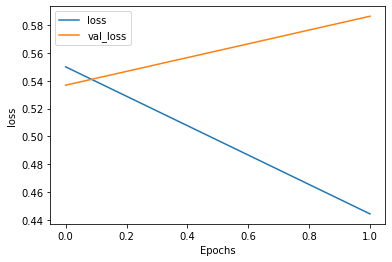

In [25]:
plot_graphs(history, 'loss')

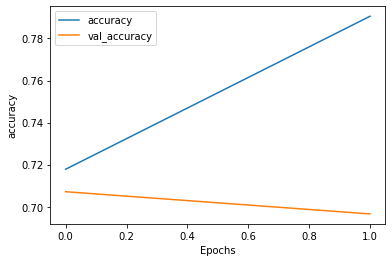

In [26]:
plot_graphs(history, 'accuracy')

#### 데이터 제출하기 

In [27]:
TEST_Q1_DATA_FILE = 'test_q1.npy'
TEST_Q2_DATA_FILE = 'test_q2.npy'
TEST_ID_DATA_FILE = 'test_id.npy'

test_q1_data = np.load(open(DATA_IN_PATH + TEST_Q1_DATA_FILE, 'rb'))
test_q2_data = np.load(open(DATA_IN_PATH + TEST_Q2_DATA_FILE, 'rb'))
test_id_data = np.load(open(DATA_IN_PATH + TEST_ID_DATA_FILE, 'rb'), allow_pickle=True)

In [28]:
# 베스트 모델 불러오기
SAVE_FILE_NM = 'weights.h5'
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [29]:
# 테스트 데이터 예측하기
predictions = model.predict((test_q1_data, test_q2_data), batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

In [30]:
output = pd.DataFrame( data={"test_id":test_id_data, "is_duplicate": list(predictions)} )
output.to_csv("cnn_predict.csv", index=False, quoting=3)